In [10]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize
import torch
from torchsummary import summary

from sklearn.model_selection import train_test_split
import random
from PIL import Image
import cv2
import rasterio as rio
import matplotlib.pyplot as plt
import time

In [20]:
# data_path = r"C:\Users\User\OneDrive - Université Bretagne Sud\01_Masters_Thesis\Project\data\toy\l1c\train"
# data_path = data_path.replace("\\", "/")
data_path = r"E:\Thesis\toy\l1c\train"

In [21]:
meta_path =  r"E:\Thesis\toy\meta_patches.csv"
metadata = pd.read_csv(meta_path)
metadata.head(5)

,patch_id,set,learn_type,lon,lat,date,climate,biome_str,biome_id,eco_str,eco_id,country,continent,origin_name,s2_gee_id,s2_l1c_id,s2_l2a_id
0,21.1424_36.6557-20170519,train,ssl,21.1424,36.6557,20170519,Ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170519T092031_20170519T092900_T34SEF,S2A_MSIL1C_20170519T092031_N0205_R093_T34SEF_2...,S2A_MSIL2A_20170519T092031_N0205_R093_T34SEF_2...
1,27.6165_38.8065-20170702,train,ssl,27.6165,38.8065,20170702,Csa,"Mediterranean Forests, Woodlands & Scrub",12.0,Aegean and Western Turkey sclerophyllous and m...,785.0,Turkey,Asia,NaN,20170702T085641_20170702T090524_T35SND,S2A_MSIL1C_20170702T085641_N0205_R007_T35SND_2...,S2A_MSIL2A_20170702T085641_N0205_R007_T35SND_2...
2,4.3601_44.7555-20170821,train,ssl,4.3601,44.7555,20170821,Cfb,Temperate Broadleaf & Mixed Forests,4.0,Western European broadleaf forests,686.0,France,Europe,NaN,20170821T104021_20170821T104208_T31TFK,S2A_MSIL1C_20170821T104021_N0205_R008_T31TFK_2...,S2A_MSIL2A_20170821T104021_N0205_R008_T31TFK_2...
3,35.1817_31.3179-20171217,train,ssl,35.1817,31.3179,20171217,BSh,Deserts & Xeric Shrublands,13.0,Mesopotamian shrub desert,830.0,Israel,Asia,NaN,20171217T082341_20171217T082801_T36RYV,S2A_MSIL1C_20171217T082341_N0206_R121_T36RYV_2...,S2A_MSIL2A_20171217T082341_N0206_R121_T36RYV_2...
4,-117.2887_33.1499-20181215,test,csl,-117.2887,33.1499,20181215,BSk,"Mediterranean Forests, Woodlands & Scrub",12.0,California coastal sage and chaparral,422.0,United States of America,North America,dw_-117.2887333221_33.1498984125-20181215_cons...,20181215T183751_20181215T184316_T11SMS,S2A_MSIL1C_20181215T183751_N0207_R027_T11SMS_2...,S2A_MSIL2A_20181215T183751_N0211_R027_T11SMS_2...


In [9]:
class TestClass(Dataset):
    def __init__(self, data_path, metadata, set, learn_type, process_level, transform=None):
    # in metadata dataframe, select patches with set as train 
        self.data_path = data_path
        self.metadata = metadata
        self.set = set
        self.transform = transform
        self.process_level = process_level
        self.learn_type = learn_type

    def __len__(self):
        return len(self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)])

    def __getitem__(self, idx):
        # return tensor pair feature,label
        # read image
        metadata_set = self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)]
        feat_fname= (f"{self.process_level}_"
                      f"{self.learn_type}_"
                      f"{metadata_set.iloc[idx, 0]}_"
                      f"feats.tif")
        label_fname= (f"{self.process_level}_"
                      f"{self.learn_type}_"
                      f"{metadata_set.iloc[idx, 0]}_"
                      f"label.tif")

        feat_p = os.path.join(self.data_path, feat_fname)
        label_p = os.path.join(self.data_path, label_fname)
        
        with rio.open(feat_p) as src:
            feat = src.read().astype(np.int16)
        with rio.open(label_p) as src:
            label = src.read().astype(np.int16)

        # handle dtypes for tensor
        feat = torch.from_numpy(feat).to(torch.int16)
        label = torch.from_numpy(label).to(torch.int16)
        # if self.transform:
        #     feat = self.transform(feat)
            # label = self.transform(label)
        return feat, label

In [5]:
batch_size = 4
dataset = TestClass(data_path, metadata, 'train', 'csl','l1c')
data = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True) # make shuffle true while training

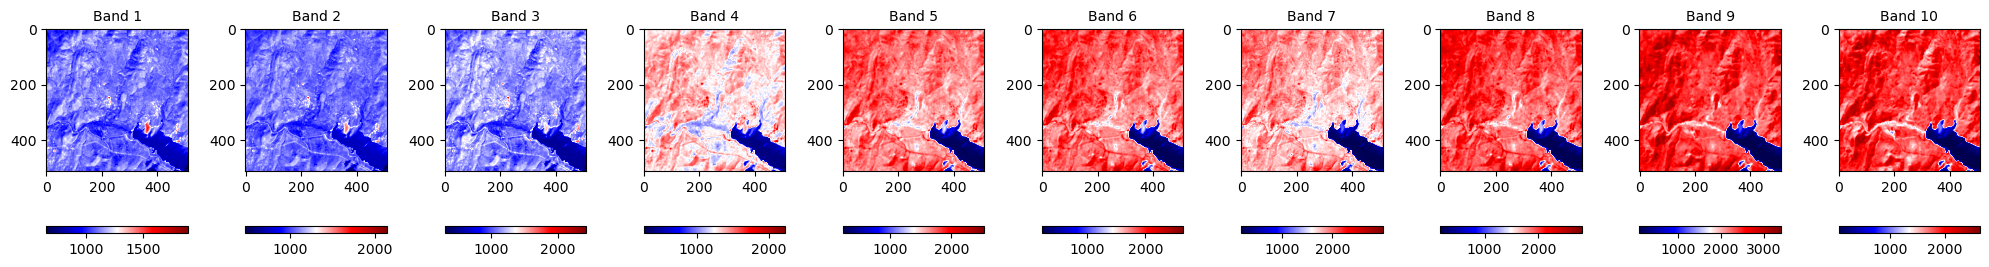

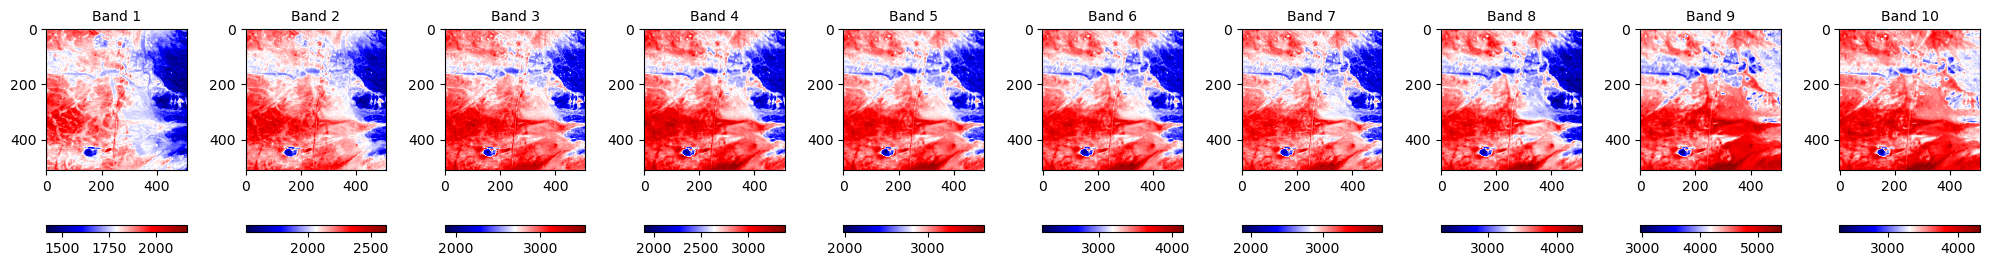

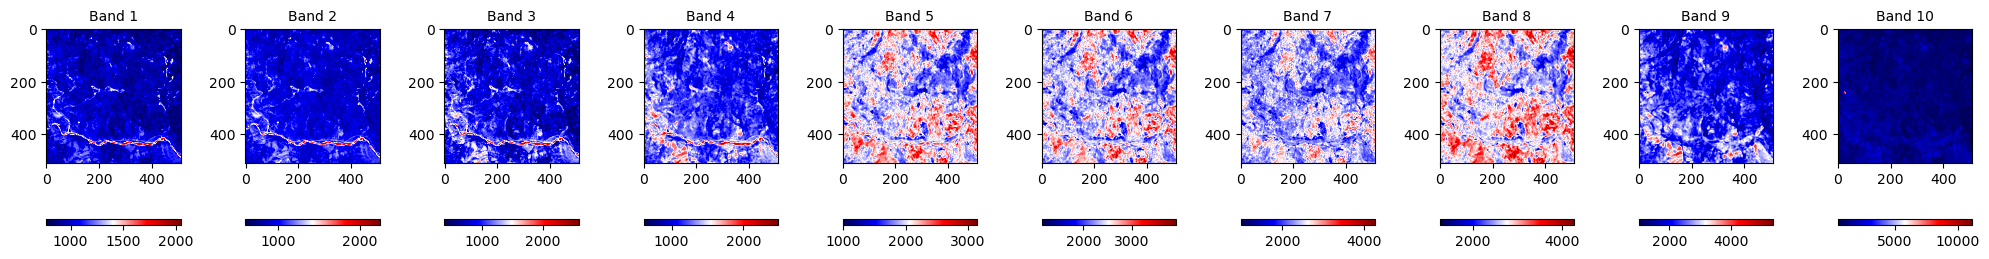

In [21]:
def visualize_data(data, random_seed=42, batch_thresh = 3):
    for batch_num, batch in enumerate(data):
        features, _ = batch
        num_bands = features.shape[1]
        
        # plot feature and label images
        fig, axes = plt.subplots(1,num_bands , figsize=(20, 4))

        # randomly choose an image,label set to display
        np.random.seed(random_seed)
        idx = np.random.choice(features.shape[0])
        for i in range(num_bands):
  
            im =axes[i].imshow(features[idx][i,:,:], cmap='seismic')
            #axes[i].set_title(feature_names[i], fontsize=10)
            axes[i].set_title(f"Band {i+1}", fontsize=10)
            sm = plt.cm.ScalarMappable(cmap='seismic')
            sm.set_array(features[idx][i,:, :])
            cbar = fig.colorbar(im, ax=axes[i], orientation = 'horizontal')

        plt.tight_layout()
        plt.show()

        if batch_num == batch_thresh:
            break

visualize_data(data, random_seed =46, batch_thresh = 3)

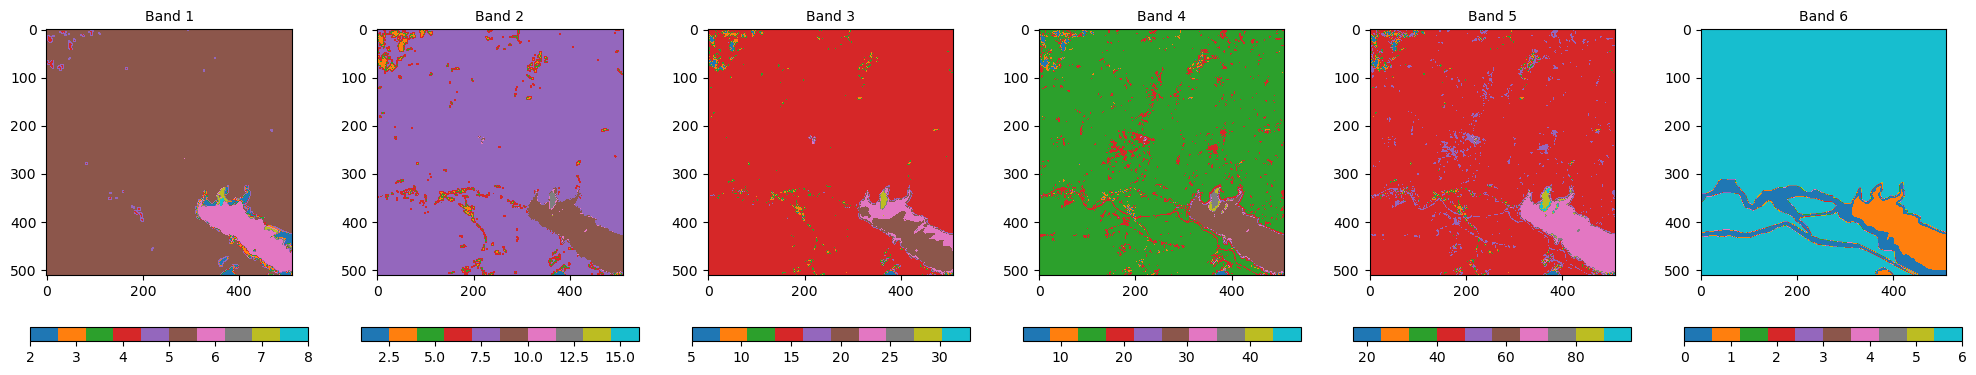

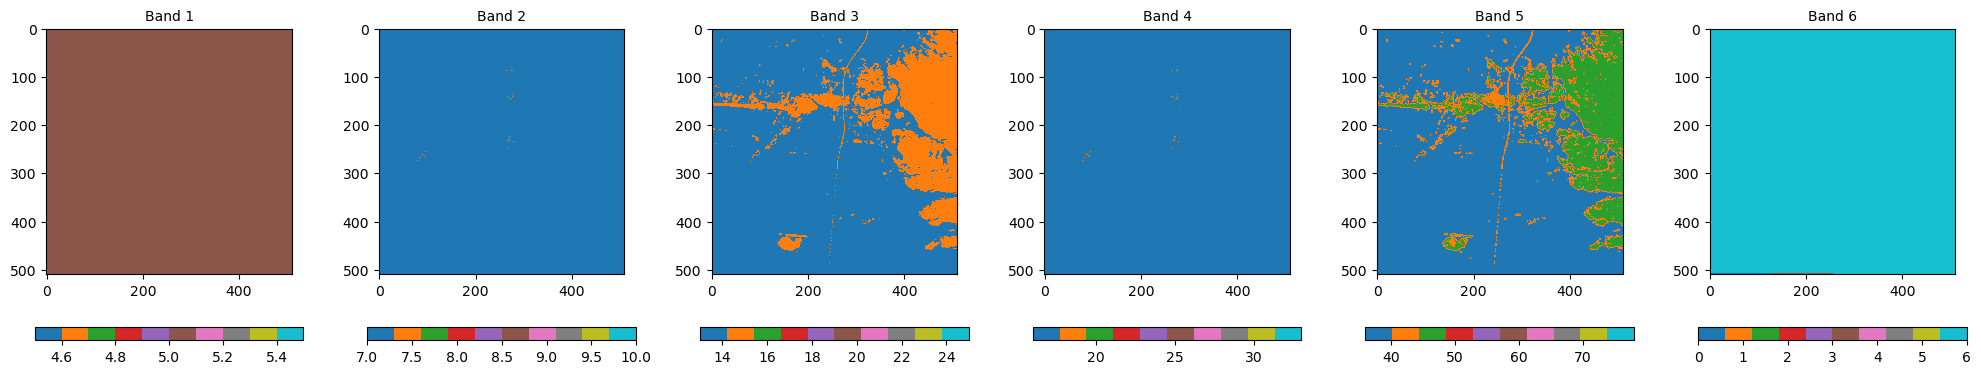

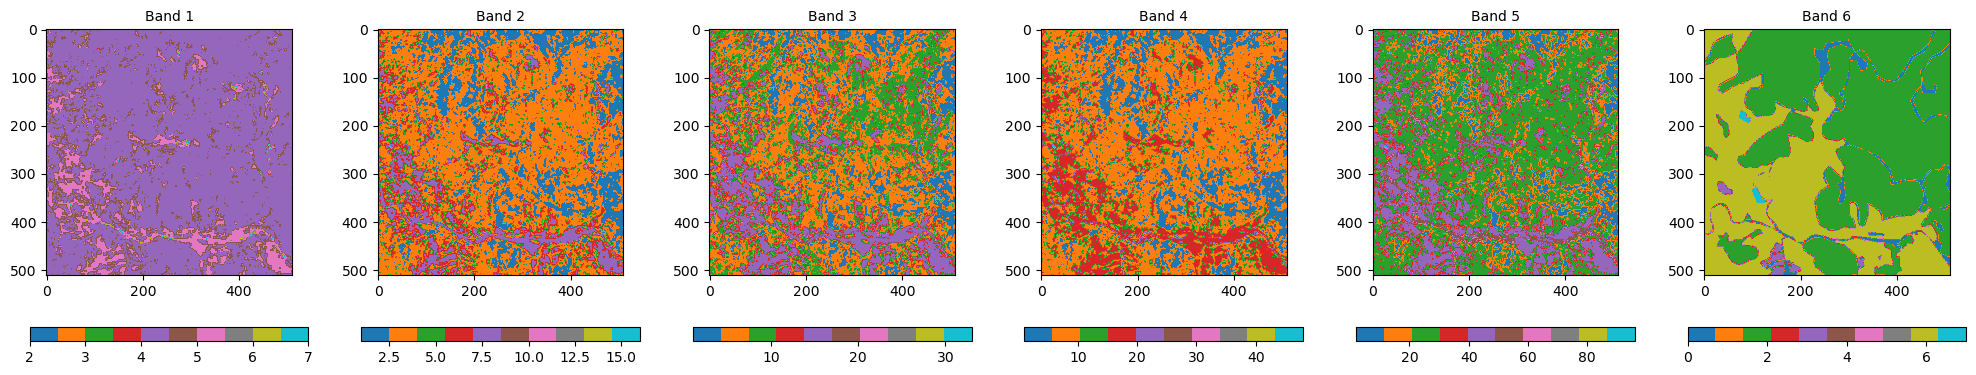

In [22]:
def visualize_labels(data, random_seed=42, batch_thresh = 3):
    for batch_num, batch in enumerate(data):
        _, labels = batch
        num_bands = labels.shape[1]

        # plot feature and label images
        fig, axes = plt.subplots(1,num_bands, figsize=(20, 4))

        # randomly choose an image,label set to display
        np.random.seed(random_seed)
        idx = np.random.choice(labels.shape[0])
        for i in range(num_bands):
            im =axes[i].imshow(labels[idx][i,:,:], cmap='tab10')
            #axes[i].set_title(feature_names[i], fontsize=10)
            axes[i].set_title(f"Band {i+1}", fontsize=10)
            sm = plt.cm.ScalarMappable(cmap='tab10')
            sm.set_array(labels[idx][i,:, :])
            cbar = fig.colorbar(im, ax=axes[i], orientation = 'horizontal')

        plt.tight_layout()
        plt.show()

        if batch_num == batch_thresh:
            break

visualize_labels(data, random_seed =46, batch_thresh = 3)

In [32]:
# modifying class to have only one band in label
class TestClass(Dataset):
    def __init__(self, data_path, metadata, set, learn_type, process_level, transform=None):
    # in metadata dataframe, select patches with set as train 
        self.data_path = data_path
        self.metadata = metadata
        self.set = set
        self.transform = transform
        self.process_level = process_level
        self.learn_type = learn_type

    def __len__(self):
        return len(self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)])

    def __getitem__(self, idx):
        # return tensor pair feature,label
        # read image
        metadata_set = self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)]
        feat_fname= (f"{self.process_level}_"
                      f"{self.learn_type}_"
                      f"{metadata_set.iloc[idx, 0]}_"
                      f"feats.tif")
        label_fname= (f"{self.process_level}_"
                      f"{self.learn_type}_"
                      f"{metadata_set.iloc[idx, 0]}_"
                      f"label.tif")

        feat_p = os.path.join(self.data_path, feat_fname)
        label_p = os.path.join(self.data_path, label_fname)
        
        with rio.open(feat_p) as src:
            feat = src.read().astype(np.int16)
        with rio.open(label_p) as src:
            label = src.read().astype(np.int16)

        # handle dtypes for tensor
        feat = torch.from_numpy(feat).to(torch.float32)
        label = torch.from_numpy(label).to(torch.float32)
        # if self.transform:
        #     feat = self.transform(feat)
            # label = self.transform(label)
        return feat, label[5,:,:].long()

In [33]:
batch_size = 4
dataset = TestClass(data_path, metadata, 'train', 'csl','l1c')
data = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True) # make shuffle true while training

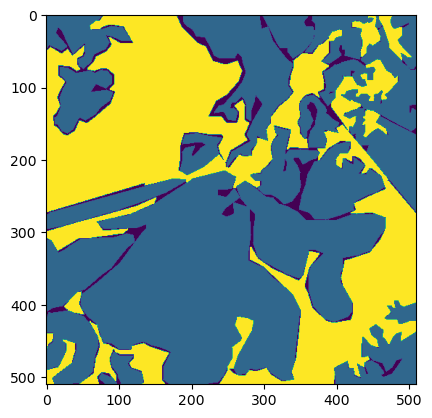

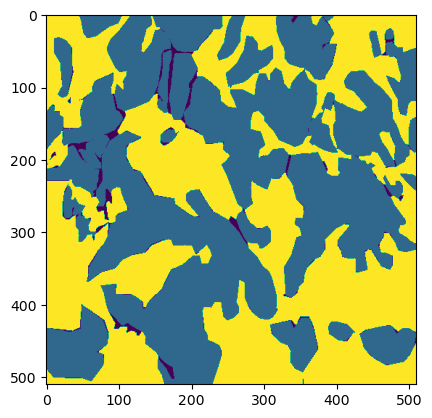

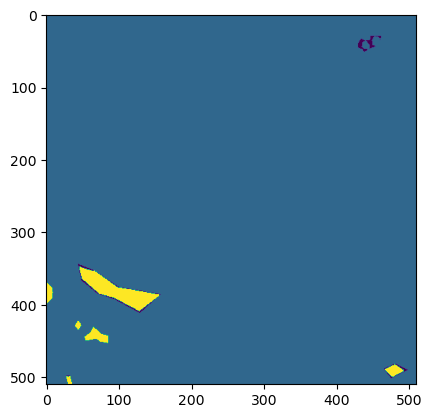

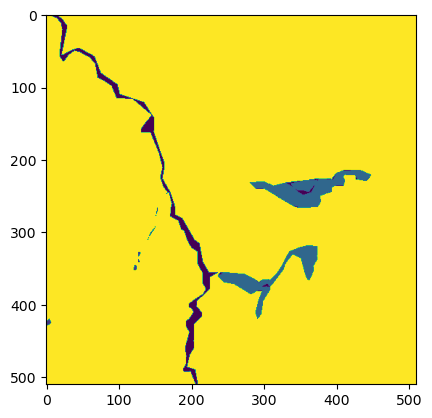

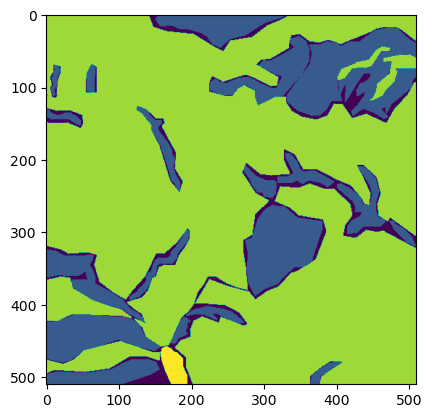

In [47]:
for batch in data:
    _, labels = batch
    plt.imshow(labels[0])
    plt.show()

### UNET Class

In [4]:
import labml_unet

In [48]:
model = labml_unet.UNet(10, 10)
summary(model, input_size=(10, 510, 510))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 510, 510]           5,824
              ReLU-2         [-1, 64, 510, 510]               0
            Conv2d-3         [-1, 64, 510, 510]          36,928
              ReLU-4         [-1, 64, 510, 510]               0
 DoubleConvolution-5         [-1, 64, 510, 510]               0
         MaxPool2d-6         [-1, 64, 255, 255]               0
        DownSample-7         [-1, 64, 255, 255]               0
            Conv2d-8        [-1, 128, 255, 255]          73,856
              ReLU-9        [-1, 128, 255, 255]               0
           Conv2d-10        [-1, 128, 255, 255]         147,584
             ReLU-11        [-1, 128, 255, 255]               0
DoubleConvolution-12        [-1, 128, 255, 255]               0
        MaxPool2d-13        [-1, 128, 127, 127]               0
       DownSample-14        [-1, 128, 1

**Notes:** Here the summary function shows 496 by 496 as output shape. But the actual output shape should be 512 by 512. The summary function is not taking into account padding and cropping 'CropAndConcat' moddule operations performed in the code.

### Training

If the labels do not start with 0 (but from 1) then may have to subtract 1 from the labels to make them start from 0. This is because the loss function expects the labels to start from 0.

In [35]:
for batch in data:
    _, labels = batch
    print(torch.amin(labels, dim = (0,2,3)))

tensor([2, 1, 1, 1, 1, 0], dtype=torch.int16)
tensor([2, 1, 1, 1, 1, 0], dtype=torch.int16)
tensor([2, 1, 1, 1, 2, 0], dtype=torch.int16)


* Accuracy
   * Get range of labels for each band in label data - Ask Felix
   * Based on this subtract necessary number of values from the labels to make them start from 0
* checkpoint saving

In [36]:
def train_epoch(model, data, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    #train_correct = 0
    for batch in data:
        features, labels = batch
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        print("outshape pre", outputs.shape)
        outputs = outputs.view(4,10,-1)
        labels = labels.view(4,-1).long()
        print("outshape post", outputs.shape)
    
        loss = criterion(outputs, labels) # loss
        loss.backward()

        #preds= torch.argmax(outputs, dim=1)
        #train_correct += torch.sum(preds == labels).item()
        optimizer.step()
        running_loss += loss.item()
    #accuracy = train_correct / (len(data) * batch_size * 510 * 510)
    return running_loss / len(data) # average loss over all batches

def validate_epoch(model, data, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch in data:
            features, labels = batch
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            labels, outputs = labels.view(4,-1).long(), outputs.view(4,10,-1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data)

In [29]:
# erly stopping, checkpoint
def train_model(model, train_data, val_data, optimizer, scheduler, criterion, device, patience,out_model_path, epochs=10):
    start = time.time()
    model = model.to(device)

    min_val_loss = np.inf
    train_loss_history = []
    val_loss_history = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} started")
        train_epoch_loss = train_epoch(model, train_data, optimizer, criterion, device)
        val_epoch_loss = validate_epoch(model, val_data, criterion, device)
        print(f"Epoch {epoch+1}/{epochs} => Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")
        train_loss_history.append(train_epoch_loss)
        val_loss_history.append(val_epoch_loss)

        patience_counter = 0
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            
            ckpt = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                    'train_loss_history': train_loss_history,
                    'val_loss_history': val_loss_history,
                    'loss': min_val_loss
                }
            torch.save(ckpt, out_model_path)
            print("Model saved")
        else:
            patience_counter += 1
            if patience_counter == patience:
                print(f"Early stopping at epoch {epoch}")
                break
        if scheduler is not None:
            scheduler.step(val_epoch_loss)

    train_duration = time.time() - start
    print(f"Training completed in {train_duration//60:.0f}m {train_duration % 60:.0f}s")

    return train_loss_history, val_loss_history

In [15]:
from milesial_unet.unet_model import UNet

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(10, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
criterion = torch.nn.CrossEntropyLoss()
patience = 5
out_model_path = 'model.pth'
epochs = 10

In [35]:
train_loss_history, val_loss_history = train_model(model, data, data, optimizer, scheduler, criterion, device, patience, out_model_path, epochs)

Epoch 1/10 started
outshape pre torch.Size([4, 10, 510, 510])
outshape post torch.Size([4, 10, 260100])
outshape pre torch.Size([4, 10, 510, 510])
outshape post torch.Size([4, 10, 260100])
outshape pre torch.Size([4, 10, 510, 510])
outshape post torch.Size([4, 10, 260100])
outshape pre torch.Size([4, 10, 510, 510])
outshape post torch.Size([4, 10, 260100])
outshape pre torch.Size([4, 10, 510, 510])
outshape post torch.Size([4, 10, 260100])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [12]:
model = UNet(10, 10)
summary(model, input_size=(10, 510, 510))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 510, 510]           5,760
       BatchNorm2d-2         [-1, 64, 510, 510]             128
              ReLU-3         [-1, 64, 510, 510]               0
            Conv2d-4         [-1, 64, 510, 510]          36,864
       BatchNorm2d-5         [-1, 64, 510, 510]             128
              ReLU-6         [-1, 64, 510, 510]               0
        DoubleConv-7         [-1, 64, 510, 510]               0
         MaxPool2d-8         [-1, 64, 255, 255]               0
            Conv2d-9        [-1, 128, 255, 255]          73,728
      BatchNorm2d-10        [-1, 128, 255, 255]             256
             ReLU-11        [-1, 128, 255, 255]               0
           Conv2d-12        [-1, 128, 255, 255]         147,456
      BatchNorm2d-13        [-1, 128, 255, 255]             256
             ReLU-14        [-1, 128, 2